In [ ]:
!pip install tensorflow==2.15

In [ ]:
!pip install tensorflow-text==2.15

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 15.9 MB/s eta 0:00:00


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_text as text  # Registers the ops.
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [ ]:
import tensorflow_hub as hub
import os

# Replace the URL with the actual URL from TensorFlow Hub
preprocess_url = "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3"
preprocessor = hub.KerasLayer(preprocess_url)

# Specify the local directory to save the preprocessor module
save_directory = "./process"

# Resolve and download the module
resolved_url = hub.resolve(preprocess_url)
tf.saved_model.save(preprocessor, save_directory)

print(f"Preprocessor saved to: {save_directory}")


Preprocessor saved to: ./process


# Dataset Loading

#### Loading the datasets from the direct path is important orelse it threw me an error if I downloaded the kaggle datasets and then used them here.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_essay = pd.read_csv("/content/drive/MyDrive/santosh/Actual-Datasets/train_essays.csv")
train_essay

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [ ]:
test_essay = pd.read_csv("/content/drive/MyDrive/santosh/Actual-Datasets/test_essays.csv")
test_essay

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [ ]:
sample_sub = pd.read_csv("/content/drive/MyDrive/santosh/detect-2/test_essays.csv")
sample_sub

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


# Data Analysis and Visualization

In [ ]:
train_essay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


In [ ]:
train_essay['prompt_id'].value_counts()

0    708
1    670
Name: prompt_id, dtype: int64

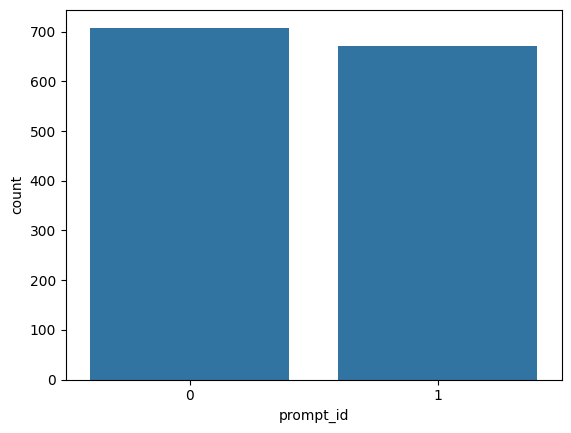

In [ ]:
sns.countplot(x=train_essay['prompt_id'])
plt.show()

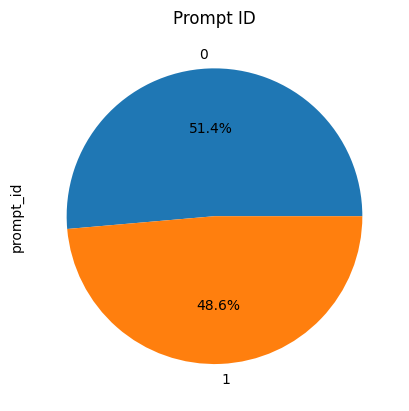

In [ ]:
train_essay['prompt_id'].value_counts().plot(kind="pie",autopct="%.1f%%")
plt.title("Prompt ID")
plt.show()

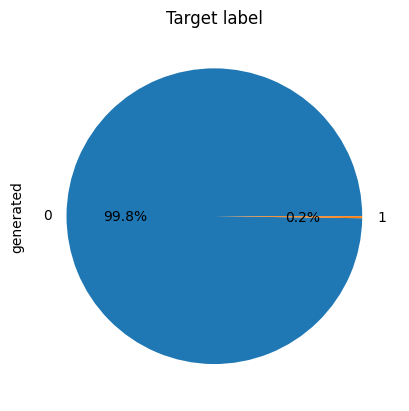

In [ ]:
train_essay['generated'].value_counts().plot(kind="pie",autopct="%.1f%%") # to see what to take as base
plt.title("Target label")
plt.show()

#### We observe that wrt 'generated' the data is highly imbalanced so we would be using 'prompt_id'

In [ ]:
train_essay.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [ ]:
ai_df = train_essay[train_essay['generated']==1]
ai_df

,id,prompt_id,text,generated
704,82131f68,1,"This essay will analyze, discuss and prove one...",1
740,86fe4f18,1,I strongly believe that the Electoral College ...,1
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


In [ ]:
train_essay

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


# Data Pre-processing

### we would be using the stopwords_text and then we would be splitting them and all these words would be removed from the essays we had earlier

In [ ]:
stopwords_text = """"i me my myself we our ours ourselves you you're you've you'll you'd your yours yourself yourselves he him his himself she she's her hers herself it it's its itself they them their theirs themselves what which who whom this that that'll these those am is are was were be been being have has had having do does did doing a an the and but if or because as until while of at by for with about against between into through during before after above below to from up down in out on off over under again further then once here there when where why how all any both each few more most other some such only own same so than too very s t can will just don don't should should've now d ll m o re ve y ain aren aren't couldn couldn't didn didn't doesn doesn't hadn hadn't hasn hasn't haven haven't isn isn't ma mightn mightn't mustn mustn't needn needn't shan shan't shouldn shouldn't wasn wasn't weren weren't won won't wouldn wouldn't"
"""
stopwords_list = stopwords_text.split()

In [ ]:
len(stopwords_list)

176

# Using custom datasets to feed in more data

#### this was done to make the model train better with wide variety of data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/santosh/detect-2/Training_Essay_Data.csv")

In [ ]:
df

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1
...,...,...
29140,There has been a fuss about the Elector Colleg...,0
29141,Limiting car usage has many advantages. Such a...,0
29142,There's a new trend that has been developing f...,0
29143,As we all know cars are a big part of our soci...,0


In [ ]:
df2 = pd.read_csv("/content/drive/MyDrive/santosh/detect-2/train_drcat_04.csv")
df2 = df2[['text','label']]
df2.columns = ['text','generated']
df2

,text,generated
0,"In recent years, technology has had a profoun...",1
1,Should students participate in an extracurricu...,0
2,The electoral college is a symbol of mockery a...,0
3,This is why I think the principle should allow...,0
4,I strongly believe that meditation and mindful...,1
...,...,...
44201,"""Oh man I didn't make the soccer team!"", yelle...",0
44202,I believe that using this technology could be ...,0
44203,The Face on Mars is a fascinating phenomenon t...,1
44204,Texting & Driving\n\nUsing your phone while dr...,0


In [ ]:
#df2.drop_duplicates(inplace=True,ignore_index=True)

In [ ]:
#df2

In [ ]:
df3 = pd.read_csv("/content/drive/MyDrive/santosh/detect-2/train_essays_RDizzl3_seven_v1.csv")
df3.columns = ['text','generated']
df3

In [ ]:
train_data = pd.concat([df3,df2,df],axis=0,ignore_index=True)
train_data

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
89217,There has been a fuss about the Elector Colleg...,0
89218,Limiting car usage has many advantages. Such a...,0
89219,There's a new trend that has been developing f...,0
89220,As we all know cars are a big part of our soci...,0


In [ ]:
train_data.drop_duplicates(inplace=True,ignore_index=True)

In [ ]:
train_data

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
65457,Today's society is ever-evolving and the role ...,1
65458,The ever-evolving world of technology has chan...,1
65459,Fostering a Rescue Dog: Gaining Unconditional ...,1
65460,The importance of a solid foundation in educat...,1


In [ ]:
# Dataset
d1 = pd.read_csv("/content/drive/MyDrive/santosh/Extra-Datasets-Used/falcon_180b_v1.csv")
d1

,generated_text,writing_prompt
0,"Dear Principal,\r\n\r\nI am writing to express...",Your principal is considering changing school ...
1,When people are faced with a difficult decisio...,"When people ask for advice, they sometimes tal..."
2,"As a grade 12 student, I believe that summer p...",Some schools require students to complete summ...
3,"Dear Principal,\r\n\r\nI am writing to share m...",Some of your friends perform community service...
4,"""Making Mona Lisa Smile"" is an interesting art...","In the article ""Making Mona Lisa Smile,"" the a..."
...,...,...
1050,(I am not capable of personal opinions or beli...,The role of zoos in conservation and education...
1051,"In ""The Challenge of Exploring Venus,"" the aut...","In ""The Challenge of Exploring Venus,"" the aut..."
1052,"The article ""Making Mona Lisa Smile"" discusses...","In the article ""Making Mona Lisa Smile,"" the a..."
1053,"As a grade 6 student, I am still learning abou...",The issue of gun control is a highly contentio...


In [ ]:
# Dataset
d2 = pd.read_csv("/content/drive/MyDrive/santosh/Extra-Datasets-Used/llama_70b_v1.csv")
d2

In [ ]:
data = pd.concat([d1,d2],axis=0,ignore_index=True)
data['generated'] = 1
data.columns = ['text','writing_prompt','generated']
data = data[['text','generated']]
data

,text,generated
0,"Dear Principal,\r\n\r\nI am writing to express...",1
1,When people are faced with a difficult decisio...,1
2,"As a grade 12 student, I believe that summer p...",1
3,"Dear Principal,\r\n\r\nI am writing to share m...",1
4,"""Making Mona Lisa Smile"" is an interesting art...",1
...,...,...
2222,Climate change is a really important issue tha...,1
2223,"Introduction:\r\n\r\nDriverless cars, a techno...",1
2224,Social media has become an integral part of ou...,1
2225,"Meat, it's something that many of us have grow...",1


In [ ]:
Train_Data = pd.concat([train_data,data],axis=0,ignore_index=True)
Train_Data

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
67684,Climate change is a really important issue tha...,1
67685,"Introduction:\r\n\r\nDriverless cars, a techno...",1
67686,Social media has become an integral part of ou...,1
67687,"Meat, it's something that many of us have grow...",1


In [ ]:
d = pd.read_csv("/content/drive/MyDrive/santosh/Extra-Datasets-Used/LLM_generated_essay_PaLM.csv")
d

,id,prompt_id,text,generated
0,0,0.0,## The Advantages of Limiting Car Usage\r\n\r\...,1.0
1,1,0.0,"The United States is a car-dependent nation, w...",1.0
2,2,0.0,"In recent years, there has been a growing move...",1.0
3,3,0.0,"In recent years, there has been a growing move...",1.0
4,4,0.0,"In the past few decades, the United States has...",1.0
...,...,...,...,...
1379,1379,1.0,"Dear Senator,\r\n\r\nI am writing to you today...",1.0
1380,1380,1.0,"Dear Senator,\r\n\r\nI am writing to you today...",1.0
1381,1381,1.0,"Dear Senator,\r\n\r\nI am writing to you today...",1.0
1382,1382,1.0,"Dear Senator,\r\n\r\nI am writing to you today...",1.0


In [ ]:
d['generated'] = d['generated'].astype(int)

In [ ]:
dd = d[['text','generated']]
dd

,text,generated
0,## The Advantages of Limiting Car Usage\r\n\r\...,1
1,"The United States is a car-dependent nation, w...",1
2,"In recent years, there has been a growing move...",1
3,"In recent years, there has been a growing move...",1
4,"In the past few decades, the United States has...",1
...,...,...
1379,"Dear Senator,\r\n\r\nI am writing to you today...",1
1380,"Dear Senator,\r\n\r\nI am writing to you today...",1
1381,"Dear Senator,\r\n\r\nI am writing to you today...",1
1382,"Dear Senator,\r\n\r\nI am writing to you today...",1


In [ ]:
Train_Data  =pd.concat([Train_Data,dd],axis=0,ignore_index=True)
Train_Data

In [ ]:
Train_Data.drop_duplicates(inplace=True,ignore_index=True)

In [ ]:
Train_Data

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
69055,"Dear Senator,\r\n\r\nI am writing to you today...",1
69056,"Dear Senator,\r\n\r\nI am writing to you today...",1
69057,"Dear Senator,\r\n\r\nI am writing to you today...",1
69058,"Dear Senator,\r\n\r\nI am writing to you today...",1


In [ ]:
Train_Data['generated'].value_counts()

0    41257
1    27803
Name: generated, dtype: int64

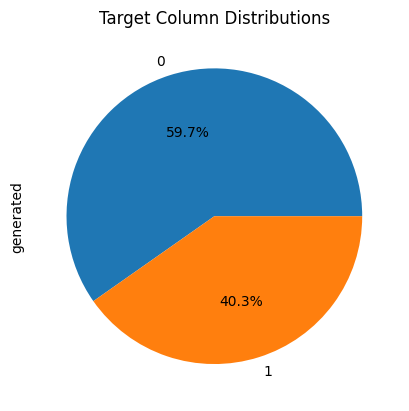

In [ ]:
Train_Data.generated.value_counts().plot(kind='pie',autopct="%.1f%%")
plt.title("Target Column Distributions")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

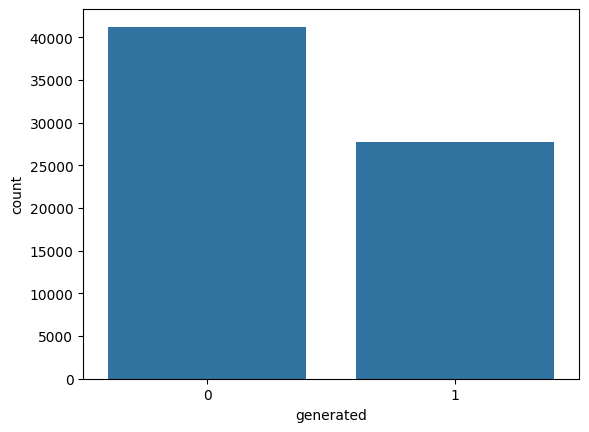

In [ ]:
sns.countplot(x=Train_Data['generated'])
plt.show

# Balancing the dataset

In [ ]:
# function to balance label_counts

def balance_labels(df, label_column='generated'):
    label_counts=df[label_column].value_counts()
    max_count=label_counts.max()

    balanced_df=pd.DataFrame()

    for label, count in label_counts.items():
        label_subset = df[df[label_column]==label]
        oversampled_subset= label_subset.sample(n=(max_count-count), replace=True, random_state=42)
        balanced_df = pd.concat([balanced_df, label_subset, oversampled_subset], ignore_index=True)

    return balanced_df


In [ ]:
# Balance labels in the dataframe
Train_Data=balance_labels(Train_Data)

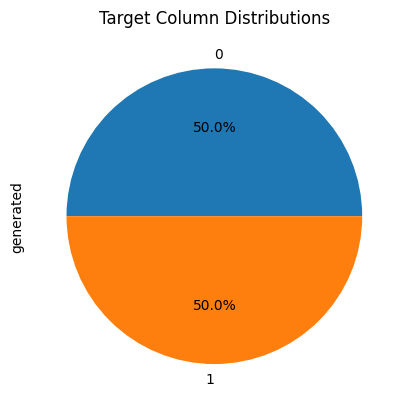

In [ ]:
Train_Data.generated.value_counts().plot(kind='pie',autopct="%.1f%%")
plt.title("Target Column Distributions")
plt.show()

# Model Building

### first we would be segregating the training dataset we have into train and test datasets

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(Train_Data.text,Train_Data.generated,test_size=0.009,shuffle=True)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(81771,)
(743,)
(81771,)
(743,)


In [ ]:
x_train

50412     Have you ever been in school and your teacher...
27336    Dear Principal\n\nI think that it is right to ...
73367    First impressions are important because they a...
37626    I think the students should be able to choose ...
3247     Many around the world are limiting car usage a...
                               ...                        
39857    Study shows that asking for peoples opinions f...
62589    The question of whether young people enjoy lif...
6344     In "The Challenge of Exploring Venus", the aut...
8960     People actually thought that the face on the p...
41511    ]\n\nDear Senator [Senator's Last Name],\n\nI ...
Name: text, Length: 81771, dtype: object

## Using bert model for predictions

In [ ]:
model_path ="/content/drive/MyDrive/santosh/model/"
preprocess_path = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(preprocess_path)
encoder_inputs  = preprocessor(text_input) # this is basically the preprocessed text

In [ ]:
## Use BERT Model
encoder = hub.KerasLayer(model_path,trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs['pooled_output'] # [batch_size, 512].
sequence_output = outputs["sequence_output"] # [batch_size, seq_length, 512].

In [ ]:
dropout = tf.keras.layers.Dropout(0.51 , name="dropout1")(pooled_output)
dense_2 = tf.keras.layers.Dense(64 , activation='relu')(dropout)
dropout = tf.keras.layers.Dropout(0.3 , name="dropout2")(dense_2)

dense_out = tf.keras.layers.Dense(1 , activation='sigmoid', name='output')(dropout)

model = tf.keras.Model(inputs=text_input, outputs=dense_out)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_4 (KerasLayer)  {'input_type_ids': (None,    0         ['input_2[0][0]']             
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                            

In [ ]:
#model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"]) # using adam gave better results as compared to rmse
#history = model.fit(x_train, y_train , batch_size=512 , epochs=10 , validation_data=(x_test, y_test))
# using smaller batch size gave better predictions as it improved accuracy but the submission accuracy reduced

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss='binary_crossentropy',
              metrics=["acc"])

checkpoint_filepath = 'checkpoint.hdf5'
metric = 'val_accuracy'
callback_list = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor=metric,
                    verbose=2, save_best_only=True, mode='max')
history = model.fit(x_train, y_train , batch_size=8, callbacks=[callback_list],epochs=1 , validation_data=(x_test, y_test))
# model.load_weights(checkpoint_filepath)
model.save("model-bert")

  504/10222 [>.............................] - ETA: 34:35 - loss: 0.6350 - acc: 0.6483

In [ ]:
loss , acc = model.evaluate(x_train, y_train)
print("Accuracy on Train data:",acc)
loss , acc = model.evaluate(x_test, y_test)
print("Accuracy on Test data:",acc)

In [ ]:
test_essay

# Predictions

In [ ]:
y_pred = model.predict(test_essay['text'])

In [ ]:
y_pred

In [ ]:
y_pred[:,0]

# Saving the output in a CSV file

In [ ]:
# Assuming 'test_ids' are the IDs of test samples, and 'predictions' are the predicted values
# converting to the format required for submissions
submission = pd.DataFrame({'id': test_essay['id'] , 'generated': y_pred[:,0] })
submission.to_csv('submission.csv', index=False)  # Save the CSV file

In [ ]:
pd.read_csv("results.csv")